# Proyek Klasifikasi Gambar: [Shoe vs Sandal vs Boot Image Dataset (15K Images)]
- **Nama:** Bayu Setyawan
- **Email:** mc568d5y1186@student.devacademy.id
- **ID Dicoding:** MC568D5Y1186

## Import Semua Packages/Library yang Digunakan

In [1]:
# Library yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

In [2]:
# Libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

In [3]:
# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


## Data Preparation

### Data Loading

In [6]:
# Import module yang disediakan google colab untuk kebutuhan upload file

from google.colab import files
files.upload()

Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"bayu123bay","key":"7a3f2bd59dfaf7c2e4eda79c5e59dcb0"}'}

In [7]:
# Membuat folder .kaggle jika belum ada
!mkdir -p ~/.kaggle

# Memindahkan file yang diupload ke direktori ~/.kaggle
!cp kaggle\ \(1\).json ~/.kaggle/kaggle.json

# Mengatur permission file agar hanya bisa dibaca user
!chmod 600 ~/.kaggle/kaggle.json


In [8]:
#!/bin/bash
!kaggle datasets download hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images

Dataset URL: https://www.kaggle.com/datasets/hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images
License(s): copyright-authors
  0% 0.00/47.0M [00:00<?, ?B/s]
100% 47.0M/47.0M [00:00<00:00, 1.40GB/s]


In [9]:
!unzip shoe-vs-sandal-vs-boot-dataset-15k-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (10).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (100).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1000).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1001).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1002).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1003).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1004).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1005).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1006).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1007).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1008).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1009).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (101).jpg  
  inflating: Shoe 

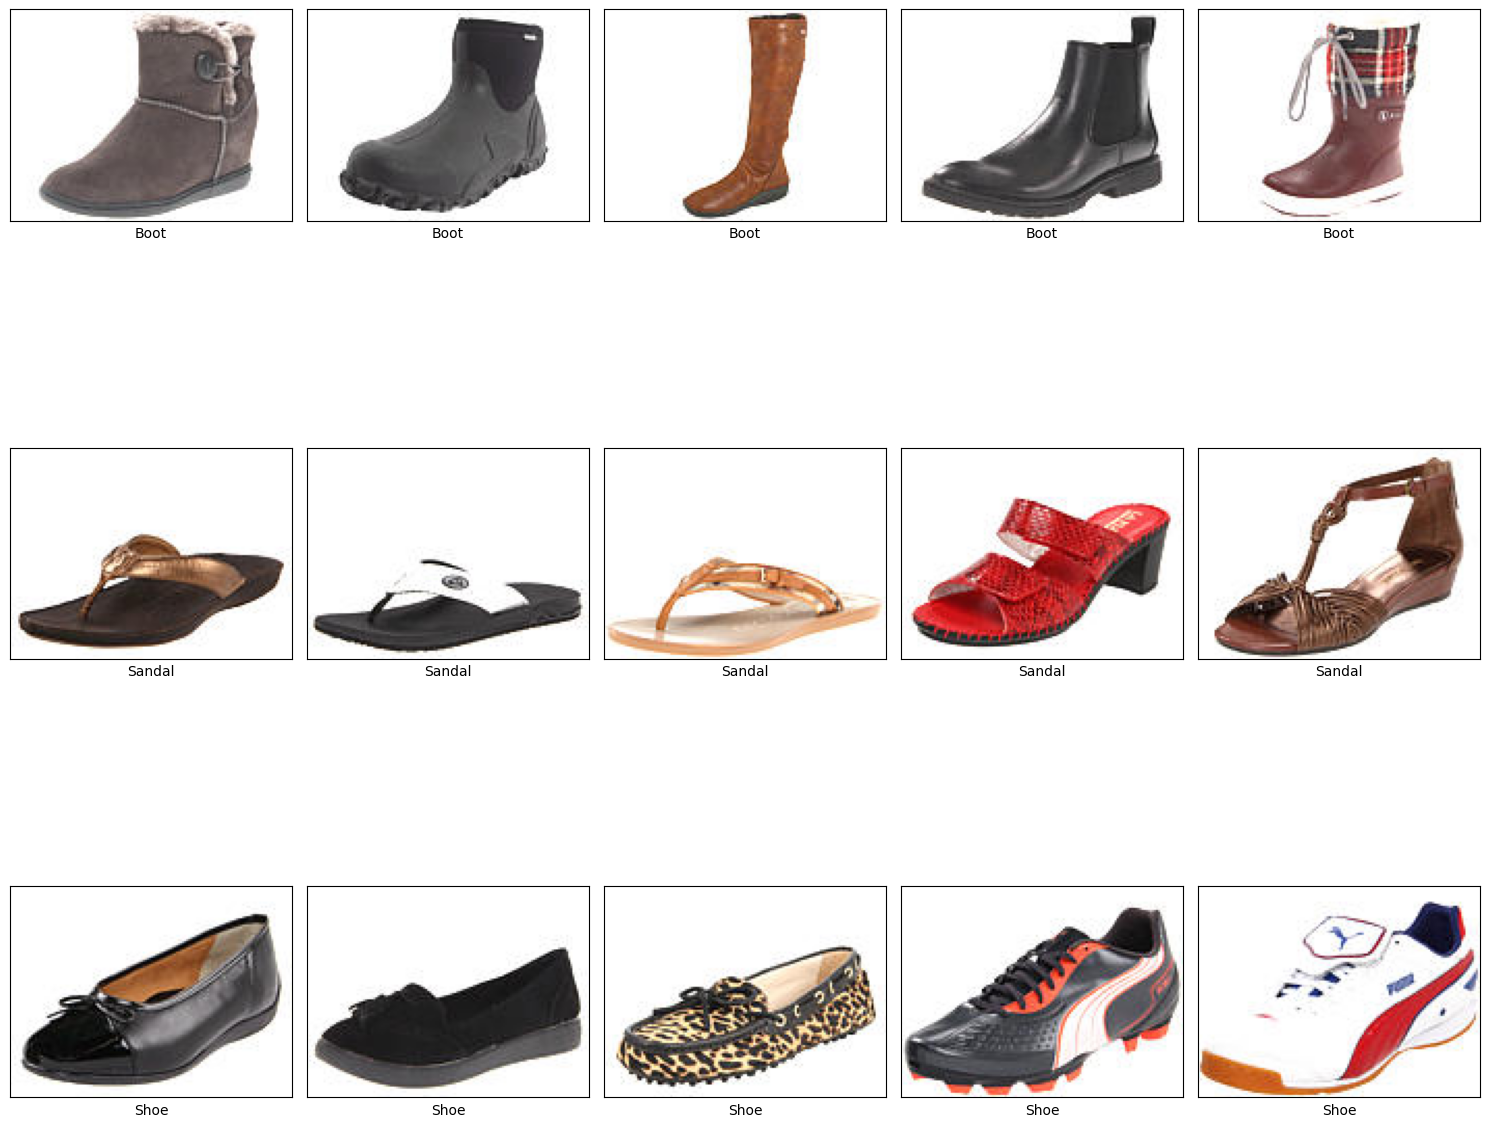

In [10]:
import matplotlib.pyplot as plt

# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
lung_image = {}

# Tentukan path sumber train
path = "/content/Shoe vs Sandal vs Boot Dataset"
for i in os.listdir(path):
    lung_image[i] = os.listdir(os.path.join(path, i))

# Menampilkan secara acak 5 gambar di bawah setiap dari 2 kelas dari data.
# Anda akan melihat gambar yang berbeda setiap kali kode ini dijalankan.
path = "/content/Shoe vs Sandal vs Boot Dataset"

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(lung_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path)):
    images = np.random.choice(lung_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path, class_name, image_name)
        img = Image.open(img_path)
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])


fig.tight_layout()

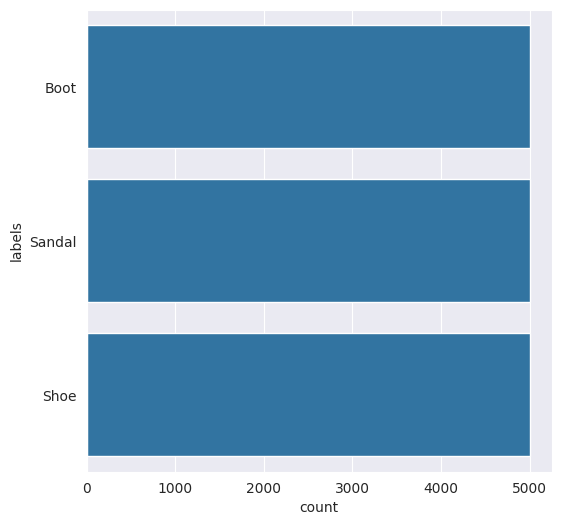

In [11]:
import seaborn as sns

# Definisikan path sumber
lung_path = "/content/Shoe vs Sandal vs Boot Dataset"

# Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(lung_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

# Plot distribusi gambar di setiap kelas
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

In [12]:
# Membuat fungsi untuk melakukan rotasi berlawanan arah jarum jam
def anticlockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    sudut = random.randint(0,180)
    return rotate(img, sudut)

# Membuat fungsi untuk melakukan rotasi searah jarum jam
def clockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    sudut = random.randint(0,180)
    return rotate(img, -sudut)

# Membuat fungsi untuk membalik gambar secara vertikal dari atas ke bawah
def flip_up_down(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return np.flipud(img)

# Membuat fungsi untuk memberikan efek peningkatan kecerahan pada gambar
def add_brightness(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    img = adjust_gamma(img, gamma=0.5,gain=1)
    return img

# Membuat fungsi untuk memberikan efek blur pada gambar
def blur_image(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return cv2.GaussianBlur(img, (9,9),0)

# Membuat fungsi untuk memberikan efek pergeseran acak pada gambar
def sheared(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(shear=0.2)
    shear_image = warp(img, transform, mode="wrap")
    return shear_image

# Membuat fungsi untuk melakukan pergeseran melengkung pada gambar
def warp_shift(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(translation=(0,40))
    warp_image = warp(img, transform, mode="wrap")
    return warp_image

### Data Preprocessing

#### Split Dataset

In [13]:
import os
import shutil
import random

# Path ke folder dataset awal (berisi Boot, Sandal, Shoe)
dataset_path = '/content/Shoe vs Sandal vs Boot Dataset'

# Folder baru untuk simpan hasil split
base_dir = '/content/split_dataset'

# Membuat folder: train, val, test dan subfolder untuk masing-masing kategori
for split in ['train', 'val', 'test']:
    for category in os.listdir(dataset_path):
        os.makedirs(os.path.join(base_dir, split, category), exist_ok=True)

# Fungsi untuk split dan copy file
def split_data(source, train_dir, val_dir, test_dir, split_ratio=(0.7, 0.15, 0.15)):
    files = [f for f in os.listdir(source) if os.path.isfile(os.path.join(source, f))]
    random.shuffle(files)
    train_size = int(split_ratio[0] * len(files))
    val_size = int(split_ratio[1] * len(files))

    for file in files[:train_size]:
        shutil.copy(os.path.join(source, file), os.path.join(train_dir, file))
    for file in files[train_size:train_size+val_size]:
        shutil.copy(os.path.join(source, file), os.path.join(val_dir, file))
    for file in files[train_size+val_size:]:
        shutil.copy(os.path.join(source, file), os.path.join(test_dir, file))

# Jalankan split untuk tiap kategori
for category in os.listdir(dataset_path):
    split_data(
        source=os.path.join(dataset_path, category),
        train_dir=os.path.join(base_dir, 'train', category),
        val_dir=os.path.join(base_dir, 'val', category),
        test_dir=os.path.join(base_dir, 'test', category)
    )

In [14]:
# Data Generator
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, 'val'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 10500 images belonging to 3 classes.
Found 2250 images belonging to 3 classes.
Found 2250 images belonging to 3 classes.


## Modelling

In [15]:
# Bangun model CNN
model_1 = Sequential()

# Conv Block 1
# Mengubah input_shape agar sesuai dengan target_size pada data generator (224, 224, 3)
model_1.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(224,224,3)))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# Conv Block 2
model_1.add(Conv2D(32, (4, 4), padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# Conv Block 3
model_1.add(Conv2D(32, (7, 7), padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# Fully Connected Layers
model_1.add(Flatten())
model_1.add(Dense(128, activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(64, activation='relu'))
model_1.add(Dropout(0.3))

# Output layer
model_1.add(Dense(3, activation='softmax'))

# Compile model
model_1.compile(optimizer=tf.keras.optimizers.RMSprop(),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# Summary
print(model_1.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 32)   │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 32)     │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,287,747 (12.54 MB)

 Trainable params: 3,287,555 (12.54 MB)

 Non-trainable params: 192 (768.00 B)

None


In [19]:
# Simpan model terbaik berdasarkan val_accuracy
checkpoint = ModelCheckpoint(
    filepath='Model_Shoes_1.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1,
)
# Train the model
history_1 = model_1.fit(
    train_generator,
    epochs=30,
    batch_size=32,
    validation_data=val_generator,
    callbacks=[checkpoint]
)

Epoch 1/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.7845 - loss: 0.5559
Epoch 1: val_accuracy improved from -inf to 0.79956, saving model to Model_Shoes_1.keras
329/329 ━━━━━━━━━━━━━━━━━━━━ 124s 375ms/step - accuracy: 0.7845 - loss: 0.5559 - val_accuracy: 0.7996 - val_loss: 0.5605
Epoch 2/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.8001 - loss: 0.5380
Epoch 2: val_accuracy did not improve from 0.79956
329/329 ━━━━━━━━━━━━━━━━━━━━ 124s 376ms/step - accuracy: 0.8000 - loss: 0.5381 - val_accuracy: 0.3373 - val_loss: 43.1058
Epoch 3/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8013 - loss: 0.5359
Epoch 3: val_accuracy did not improve from 0.79956
329/329 ━━━━━━━━━━━━━━━━━━━━ 124s 376ms/step - accuracy: 0.8013 - loss: 0.5359 - val_accuracy: 0.4218 - val_loss: 1.6765
Epoch 4/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.7969 - loss: 0.5294
Epoch 4: val_accuracy did not improve from 0.79956
329/329 ━━━━━━━━━━━━━━━━━━━━ 124s 377ms/st

## Evaluasi dan Visualisasi

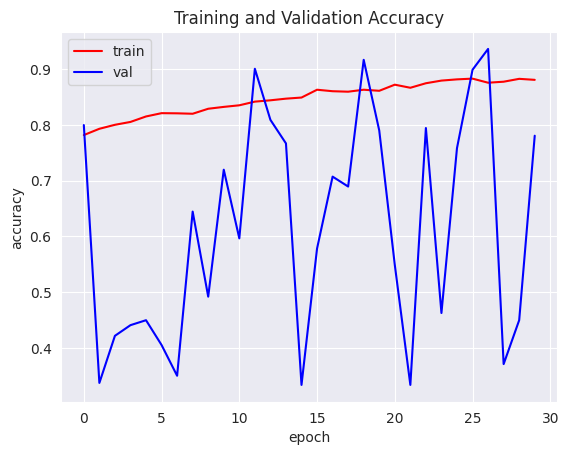

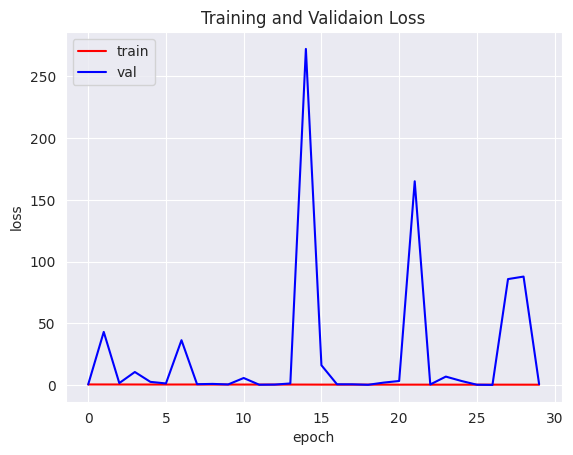

In [20]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

In [32]:
model_1.save("model.h5")



              precision    recall  f1-score   support

        Boot     0.8017    0.9867    0.8846       750
      Sandal     0.7229    0.9427    0.8183       750
        Shoe     0.9971    0.4640    0.6333       750

    accuracy                         0.7978      2250
   macro avg     0.8406    0.7978    0.7787      2250
weighted avg     0.8406    0.7978    0.7787      2250



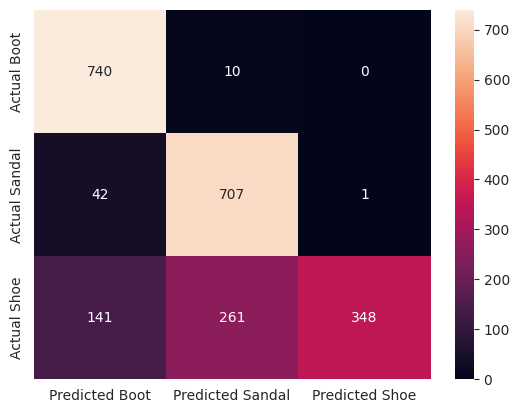

In [25]:
test_generator.reset()

# Prediksi probabilitas tiap kelas
preds_1 = model_1.predict(test_generator, verbose=0)

# Ambil kelas dengan probabilitas tertinggi
preds_1 = np.argmax(preds_1, axis=1)

# Confusion Matrix
cm = pd.DataFrame(
    data=confusion_matrix(test_generator.classes, preds_1, labels=[0, 1, 2]),
    index=["Actual Boot", "Actual Sandal", "Actual Shoe"],
    columns=["Predicted Boot", "Predicted Sandal", "Predicted Shoe"]
)
sns.heatmap(cm, annot=True, fmt="d")

# Classification Report
print("\n")
print(classification_report(
    y_true=test_generator.classes,
    y_pred=preds_1,
    target_names=['Boot', 'Sandal', 'Shoe'],
    digits=4
))


## Konversi Model

In [28]:
# Save Model
model_1.save('animalfaces_model.keras')

converter = tf.lite.TFLiteConverter.from_keras_model(model_1)
tflite_model = converter.convert()

Saved artifact at '/tmp/tmpg0spd0i_'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  132508598428752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132508598431824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132508598434128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132508598435472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132508598435280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132508598433552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132508598435664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132508524458448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132508524459024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132508524460176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13250852445806

In [34]:
# Install tensorflowjs
!pip install tensorflowjs

# Import tensorflowjs
import tensorflowjs as tfjs

# Save Model
model_1.save('animalfaces_model.keras')

converter = tf.lite.TFLiteConverter.from_keras_model(model_1)
tflite_model = converter.convert()

# Konversi model ke format TensorFlow.js
tfjs.converters.save_keras_model(model_1, 'model_tfjs')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.1 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
google-cloud-bigquery 3.32.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


Saved artifact at '/tmp/tmp993akdq0'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  132508598428752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132508598431824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132508598434128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132508598435472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132508598435280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132508598433552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132508598435664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132508524458448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132508524459024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132508524460176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13250852445806

failed to lookup keras version from the file,
    this is likely a weight only file


In [36]:
# Konversi model ke TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model_1)
tflite_model = converter.convert()

# Simpan model dalam format .tflite
with open("model.tflite", "wb") as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpt2zno3jq'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  132508598428752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132508598431824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132508598434128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132508598435472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132508598435280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132508598433552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132508598435664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132508524458448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132508524459024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132508524460176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13250852445806

In [40]:
save_path = os.path.join("models?")
tf.saved_model.save(model_1, save_path)

In [44]:
!zip -r models.zip models
files.download('models.zip')

  adding: models/ (stored 0%)
  adding: models/rps_model/ (stored 0%)
  adding: models/rps_model/fingerprint.pb (stored 0%)
  adding: models/rps_model/assets/ (stored 0%)
  adding: models/rps_model/variables/ (stored 0%)
  adding: models/rps_model/variables/variables.index (deflated 65%)
  adding: models/rps_model/variables/variables.data-00000-of-00001 (deflated 36%)
  adding: models/rps_model/saved_model.pb (deflated 88%)
  adding: models/rps_model/1/ (stored 0%)
  adding: models/rps_model/1/fingerprint.pb (stored 0%)
  adding: models/rps_model/1/assets/ (stored 0%)
  adding: models/rps_model/1/variables/ (stored 0%)
  adding: models/rps_model/1/variables/variables.index (deflated 65%)
  adding: models/rps_model/1/variables/variables.data-00000-of-00001 (deflated 36%)
  adding: models/rps_model/1/saved_model.pb (deflated 87%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Inference (Optional)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


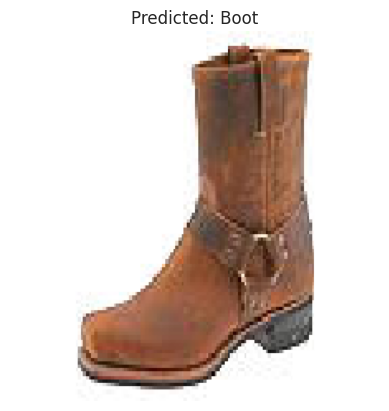

In [30]:
from tensorflow.keras.preprocessing import image

# Load model dari .keras
loaded_model = tf.keras.models.load_model('animalfaces_model.keras')

# Ambil contoh gambar
sample_path = test_generator.filepaths[0]
img = image.load_img(sample_path, target_size=IMG_SIZE)
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Prediksi
prediction = loaded_model.predict(img_array)
predicted_class = np.argmax(prediction)
class_labels = list(train_generator.class_indices.keys())

# Tampilkan hasil
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted: {class_labels[predicted_class]}")
plt.show()

In [45]:
!pip freeze > requirements.txt
from google.colab import files
files.download('requirements.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>